In [13]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline  

2023-04-23 21:46:21.459109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generate meta-training and meta-testing data

In [57]:
from exp1_noisy_sinusoids import Noise_Env_clipped_X

env_extra_noise = Noise_Env_clipped_X()
meta_train_data = env_extra_noise.generate_meta_train_data(n_tasks=200, n_samples=5)
meta_test_data = env_extra_noise.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=200)

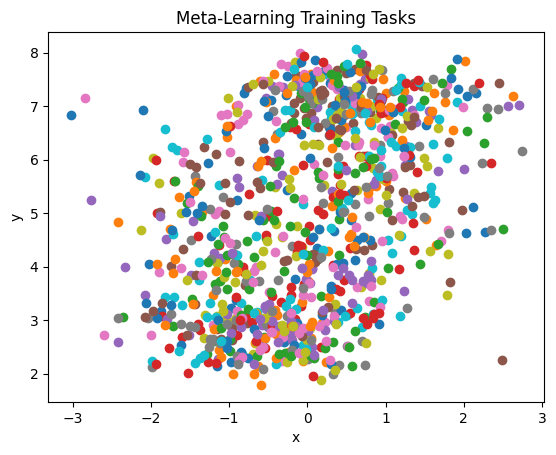

In [64]:
from matplotlib import pyplot as plt
%matplotlib inline
#for x_context, y_context, x_test, y_test in meta_test_data[:5]:
 #   plt.scatter(x_test, y_test)
for x_test, y_test in meta_train_data[:200]:
    plt.scatter(x_test, y_test)
plt.title('Meta-Learning Training Tasks')
plt.xlabel('x')
plt.ylabel('y')


plt.show()

## MAML

In [59]:
from meta_learn import MAML
from matplotlib import pyplot as plt

meta_learner = MAMLRegression(meta_train_data, task_batch_size=10, num_iter_fit=20000)
meta_learner.meta_fit(meta_test_data[:200], log_period=1000)

[2023-04-24 10:51:51,543 -INFO]  Iter 1/20000 - Loss: 0.708094 - Time 0.11 sec Valid-RMSE: 1.706 
[2023-04-24 10:52:18,400 -INFO]  Iter 1000/20000 - Loss: 0.274613 - Time 26.86 sec Valid-RMSE: 1.315 
[2023-04-24 10:52:49,788 -INFO]  Iter 2000/20000 - Loss: 0.216128 - Time 29.83 sec Valid-RMSE: 1.197 
[2023-04-24 10:53:19,745 -INFO]  Iter 3000/20000 - Loss: 0.185977 - Time 28.57 sec Valid-RMSE: 1.113 
[2023-04-24 10:53:40,901 -INFO]  Iter 4000/20000 - Loss: 0.162094 - Time 20.17 sec Valid-RMSE: 1.131 
[2023-04-24 10:54:00,150 -INFO]  Iter 5000/20000 - Loss: 0.146950 - Time 17.65 sec Valid-RMSE: 1.126 
[2023-04-24 10:54:26,291 -INFO]  Iter 6000/20000 - Loss: 0.141681 - Time 25.27 sec Valid-RMSE: 1.103 
[2023-04-24 10:54:45,678 -INFO]  Iter 7000/20000 - Loss: 0.134497 - Time 18.66 sec Valid-RMSE: 1.117 
[2023-04-24 10:55:03,764 -INFO]  Iter 8000/20000 - Loss: 0.124131 - Time 17.50 sec Valid-RMSE: 1.168 
[2023-04-24 10:55:25,876 -INFO]  Iter 9000/20000 - Loss: 0.121361 - Time 20.88 sec Val

0.09955599904060364

/var/folders/v9/1l9jmkf14cg25_5d_j2jbyy80000gn/T/ipykernel_13618/1972697422.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


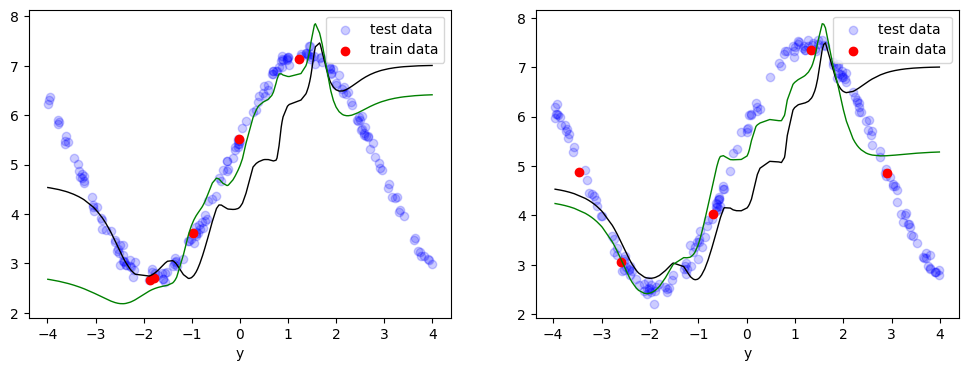

In [63]:
fig, axes = plt.subplots(1, 2 , figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    idx = np.argsort(x_test, axis=0).flatten()
    x_test,  y_test = x_test[idx], y_test[idx]

    rmse = meta_learner.eval(x_context, y_context, x_test, y_test)

    y_pred_post, y_pred_pre = meta_learner.predict(x_context, y_context, x_test)


    
    x_plot = tf.range(-4, 4, 0.1)
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].plot(x_test, y_pred_pre, color='black', linewidth=1.0)
    axes[i].plot(x_test, y_pred_post, 'green', linewidth=1.0)
    
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')
    
fig.show()

In [10]:
import time
import torch.nn as nn
import math
import torch
import numpy as np

from meta_learn.models import NeuralNetwork
from meta_learn.abstract import RegressionModelMetaLearned
from meta_learn.util import DummyLRScheduler, _handle_input_dimensionality

from config import device

class MAMLRegression(RegressionModelMetaLearned):

    def __init__(self, meta_train_data, layer_sizes=(32, 32, 32, 32), num_iter_fit=20000, lr_inner=0.05, num_inner_steps=1,
                 task_batch_size=5, lr_meta=1e-3, lr_decay=1.0, optimizer='Adam', normalize_data=True, random_seed=None):
        """
        Few Shot Regression with Model-Agnostic Meta-Learning (MAML)

        Args:
            meta_train_data: list of tuples of ndarrays[(train_x_1, train_t_1), ..., (train_x_n, train_t_n)]
            layer_sizes: (tuple) hidden layer sizes of  NN
            num_iter_fit: (int) number of gradient steps for fitting the parameters
            lr_inner: (float) learning rate for (inner) adaptation steps
            num_inner_steps: (int) number of inner gradient-steps
            task_batch_size (int): number of tasks for estimating the meta-gradient in each iteration
            lr_meta: (float) learning rate for optimizing the meta-objective
            lr_decay: (float) multiplicative lr decay factor applied after every 1000 gradient steps
            optimizer: (str) type of optimizer to use - must be either 'Adam' or 'SGD'
            normalize_data: (bool) whether to normalize the data
            random_seed: (int) seed for pytorch and numpy rng
        """
        super().__init__(normalize_data, random_seed)

        assert optimizer in ['Adam', 'SGD']

        # prepare data
        self._check_meta_data_shapes(meta_train_data)
        self._compute_normalization_stats(meta_train_data)

        self.meta_train_data = [self._prepare_data_per_task(train_x, train_y, flatten_y=False)
                                                                for train_x, train_y in meta_train_data]

        self.nn = NeuralNetwork(self.input_dim, self.output_dim, layer_sizes=layer_sizes)
        self.initial_params = list(self.nn.parameters())
        self.num_inner_steps = num_inner_steps
        self.lr_inner = lr_inner
        self.task_batch_size = task_batch_size
        self.num_iter_fit = num_iter_fit

        self.loss_fn = nn.MSELoss()

        # c) prepare inference
        self._setup_optimizer(optimizer, lr_meta, lr_decay)

        self.fitted = False

    def meta_fit(self, valid_tuples=None, verbose=True, log_period=500, n_iter=None):
        """
        fits the initial params via MAML

        Args:
            valid_tuples: list of valid tuples, i.e. [(test_context_x_1, test_context_t_1, test_x_1, test_t_1), ...]
            verbose: (boolean) whether to print training progress
            log_period: (int) number of steps after which to print stats
            n_iter: (int) number of gradient descent iterations
        """

        assert (valid_tuples is None) or (all([len(valid_tuple) == 4 for valid_tuple in valid_tuples]))

        t = time.time()

        if n_iter is None:
            n_iter = self.num_iter_fit

        cum_loss = 0.0

        for itr in range(1, n_iter + 1):

            task_batch_indices = self.rds_numpy.choice(len(self.meta_train_data), size=self.task_batch_size)
            meta_train_tuples = [self.meta_train_data[idx] for idx in task_batch_indices]
            loss = self._meta_step(meta_train_tuples)

            self.lr_scheduler.step()

            cum_loss += loss

            # print training stats stats
            if itr == 1 or itr % log_period == 0:
                duration = time.time() - t
                avg_loss = cum_loss / (log_period if itr > 1 else 1.0)
                cum_loss = 0.0
                t = time.time()

                message = 'Iter %d/%d - Loss: %.6f - Time %.2f sec' % (itr, self.num_iter_fit, avg_loss.item(), duration)

                # if validation data is provided  -> compute the valid log-likelihood
                if valid_tuples is not None:
                    valid_rmse = self.eval_datasets(valid_tuples)
                    message += ' Valid-RMSE: %.3f ' % valid_rmse

                if verbose:
                    self.logger.info(message)


        self.fitted = True

        return loss.item()

    def predict(self, context_x, context_y, test_x, return_tensor=False, num_steps_eval=None):
        """
        adapts the initial (MAML) parameters based on the context data and compute prediction for test_x

        Args:
            context_x: (ndarray) context input data for which to compute the posterior
            context_y: (ndarray) context targets for which to compute the posterior
            test_x: (ndarray) query input data of shape (n_samples, ndim_x)
            return_tensor: (bool) whether return a torch tensor or a numpy array
            num_steps_eval: (int) number of adaptation steps

        Returns:
            pred_mean: predicted mean corresponding to test_x
        """

        context_x, context_y = _handle_input_dimensionality(context_x, context_y)
        test_x = _handle_input_dimensionality(test_x)
        assert test_x.shape[1] == context_x.shape[1]

        # normalize data and convert to tensor
        context_x, context_y = self._prepare_data_per_task(context_x, context_y, flatten_y=False)

        test_x = self._normalize_data(X=test_x, Y=None)
        test_x = torch.from_numpy(test_x).float().to(device)

        # perform adaptation steps on context data
        adapted_params = self._eval_steps(context_x, context_y, num_steps_eval=num_steps_eval)
        with torch.no_grad():
            y_pred = self.nn.forward_parametrized(test_x, adapted_params)
            y_pred = y_pred * torch.Tensor(self.y_std).float()[None, :] + torch.Tensor(self.y_mean).float()[None, :]

            y_pred2 = self.nn.forward_parametrized(test_x, self.initial_params)
            y_pred2 = y_pred2 * torch.Tensor(self.y_std).float()[None, :] + torch.Tensor(self.y_mean).float()[None, :]

            if return_tensor:
                return y_pred
            else:
                return y_pred.cpu().numpy(), y_pred2.cpu().numpy()

    def eval(self, context_x, context_y, test_x, test_y, num_steps_eval=None):
        """
           Computes the rmse on the test data after adapting the parameters to the context data

           Args:
               context_x: (ndarray) context input data for which to compute the posterior
               context_y: (ndarray) context targets for which to compute the posterior
               test_x: (ndarray) test input data of shape (n_samples, ndim_x)
               test_y: (ndarray) test target data of shape (n_samples, ndim_y)

           Returns: rmse

        """
        test_x, test_y = _handle_input_dimensionality(test_x, test_y)
        test_y_tensor = torch.from_numpy(test_y).float().to(device)

        y_pred = self.predict(context_x, context_y, test_x, return_tensor=True, num_steps_eval=num_steps_eval)

        # print(self.loss_fn(y_pred, test_y_tensor).item())
        rmse = torch.mean(torch.sum(torch.pow(y_pred - test_y_tensor, 2), dim=-1)).sqrt()

        return rmse.cpu().item()

    def eval_datasets(self, test_tuples, **kwargs):
        """
           Computes the average test rmse over multiple test datasets

           Args:
               test_tuples: list of test set tuples, i.e. [(test_context_x_1, test_context_y_1, test_x_1, test_y_1), ...]

           Returns: rmse
        """
        assert (all([len(valid_tuple) == 4 for valid_tuple in test_tuples]))

        rmse_list = [self.eval(*test_data_tuple, **kwargs) for test_data_tuple in test_tuples]

        return np.mean(rmse_list)

    def _setup_optimizer(self, optimizer, lr, lr_decay):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.initial_params, lr=lr)
        elif optimizer == 'SGD':
            self.optimizer = torch.optim.SGD(self.initial_params, lr=lr)
        else:
            raise NotImplementedError('Optimizer must be Adam or SGD')

        if lr_decay < 1.0:
            self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1000, gamma=lr_decay)
        else:
            self.lr_scheduler = DummyLRScheduler()

    def _inner_steps(self, x_data, y_data):
        # split data into two parts
        idx_split = math.ceil(x_data.shape[0] / 2.0)
        x_1, y_1 = x_data[:idx_split], y_data[:idx_split] # data for inner update
        x_2, y_2 = x_data[idx_split:], y_data[idx_split:] # data for computing meta loss

        # clone initial parameters
        temp_params = [param.clone() for param in self.initial_params]

        # inner steps
        for step in range(self.num_inner_steps):
            mse_loss = self.loss_fn(self.nn.forward_parametrized(x_1, temp_params), y_1)
            # compute grad and update inner params
            grads = torch.autograd.grad(mse_loss, temp_params, create_graph=True)
            temp_params = [p - self.lr_inner * g for p, g in zip(temp_params, grads)]

        # compute meta-objective
        task_loss = self.loss_fn(self.nn.forward_parametrized(x_2, temp_params), y_2)

        return task_loss

    def _meta_step(self, train_task_tuples):
        self.optimizer.zero_grad()

        meta_loss = 0.0
        for x_train, y_train in train_task_tuples:
            meta_loss += self._inner_steps(x_train, y_train)
        meta_loss /= len(train_task_tuples)

        # compute meta gradient of loss with respect to maml initial_params
        meta_grads = torch.autograd.grad(meta_loss, self.initial_params)

        # assign meta gradient to initial_params and take optimisation step
        for w, g in zip(self.initial_params, meta_grads):
            w.grad = g
        self.optimizer.step()
        return meta_loss

    def _eval_steps(self, x_data, y_data, num_steps_eval=None):

        if num_steps_eval is None:
            num_steps_eval = self.num_inner_steps

        temp_params = [param.clone() for param in self.initial_params]

        # inner steps
        for step in range(num_steps_eval):
            mse_loss = self.loss_fn(self.nn.forward_parametrized(x_data, temp_params), y_data)

            # compute grad and update inner params
            grads = torch.autograd.grad(mse_loss, temp_params, create_graph=False)
            temp_params = [p - self.lr_inner * g for p, g in zip(temp_params, grads)]
        return temp_params




## Meta-Training with PACOH-MAP

In [23]:
from meta_learn import GPRegressionMetaLearned

meta_gp = GPRegressionMetaLearned(meta_train_data, weight_decay=0.2, num_iter_fit=20000, random_seed=30)
meta_gp.meta_fit(meta_test_data, log_period=1000)

/Users/klemens/Desktop/III_essy_coding/Experiment_1_PACOH_GP/exp_PACOH_GP/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
[2023-04-23 22:10:02,951 -INFO]  Iter 1/20000 - Loss: 6.035603 - Time 0.22 sec - Valid-LL: -1.769 - Valid-RMSE: 1.725 - Calib-Err 0.110
[2023-04-23 22:10:23,438 -INFO]  Iter 1000/20000 - Loss: 5.266715 - Time 20.77 sec - Valid-LL: -1.071 - Valid-RMSE: 1.250 - Calib-Err 0.097
[2023-04-23 22:10:41,167 

0.8395566940307617

## Meta-Testing with PACOH-MAP

In [24]:
ll, rmse, calib_err = meta_gp.eval_datasets(meta_test_data)
print('Test log-likelihood:', ll)
print('Test RMSE:', rmse)
print('Test calibration error:', calib_err)

Test log-likelihood: 0.46646307557821276
Test RMSE: 0.9114134572446346
Test calibration error: 0.11446476634591818


In [ ]:
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    idx = np.argsort(x_test, axis=0).flatten()
    x_test,  y_test = x_test[idx], y_test[idx]

    rmse = meta_learner.eval(x_context, y_context, x_test, y_test)

    y_pred_post, y_pred_pre = meta_learner.predict(x_context, y_context, x_test)


    
    x_plot = tf.range(-4, 4, 0.1)
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].plot(x_test, y_pred_pre, color='black', linewidth=1.0)
    axes[i].plot(x_test, y_pred_post, 'green', linewidth=1.0)
    
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')
    
fig.show()

/var/folders/v9/1l9jmkf14cg25_5d_j2jbyy80000gn/T/ipykernel_13618/1539838265.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


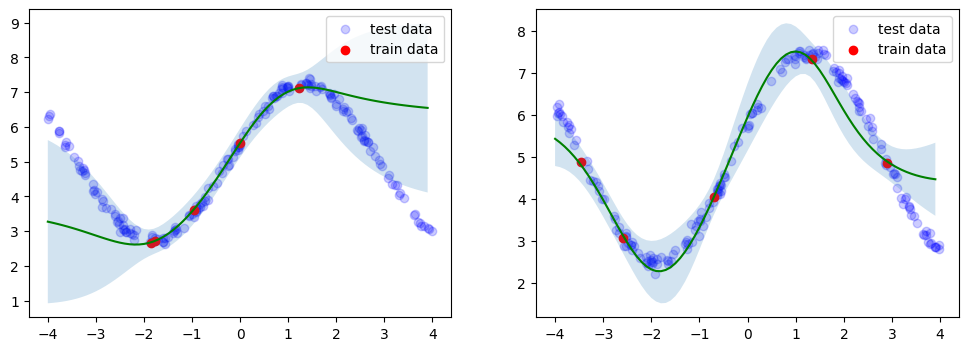

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]

    pred_mean, pred_std = meta_gp.predict(x_context, y_context, x_plot)
    ucb, lcb = meta_gp.confidence_intervals(x_context, y_context, np.array(x_plot), confidence=0.9)
    
    x_plot = tf.range(-4, 4, 0.1)

    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")

    axes[i].plot(x_plot, pred_mean, color='green')
    axes[i].fill_between(x_plot, lcb, ucb, alpha=0.2)
    axes[i].legend()
    
fig.show()

In [8]:
""" A) generate meta-training and meta-testing data """
from experiments.data_sim import SinusoidDataset
task_environment = SinusoidDataset()
meta_train_data = task_environment.generate_meta_train_data(n_tasks=20, n_samples=5)
meta_test_data = task_environment.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=50)


""" B) Meta-Learning with PACOH-MAP """
from meta_learn import GPRegressionMetaLearned
meta_gp = GPRegressionMetaLearned(meta_train_data, weight_decay=0.2)
meta_gp.meta_fit(meta_test_data, log_period=1000)


"""  C) Meta-Testing with PACOH-MAP """
x_context, y_context, x_test, y_test = meta_test_data[0]

# target training in (x_ontext, y_context) & predictions for x_test
pred_mean, pred_std = meta_gp.predict(x_context, y_context, x_test)

# confidence intervals predictions in x_test 
ucb, lcb = meta_gp.confidence_intervals(x_context, y_context, x_test, confidence=0.9)

# compute evaluation metrics on one target task
log_likelihood, rmse, calib_error = meta_gp.eval(x_context, y_context, x_test, y_test)

# compute evaluation metrics for multiple tasks / test datasets
log_likelihood, rmse, calib_error = meta_gp.eval_datasets(meta_test_data)

[2020-02-11 10:05:32,241 -INFO]  Iter 1/10000 - Loss: 6.730902 - Time 0.02 sec - Valid-LL: -1.779 - Valid-RMSE: 1.684 - Calib-Err 0.118
[2020-02-11 10:05:52,925 -INFO]  Iter 1000/10000 - Loss: 4.964087 - Time 20.64 sec - Valid-LL: -1.245 - Valid-RMSE: 0.738 - Calib-Err 0.115
[2020-02-11 10:06:17,925 -INFO]  Iter 2000/10000 - Loss: 3.998452 - Time 24.75 sec - Valid-LL: -0.967 - Valid-RMSE: 0.643 - Calib-Err 0.110
[2020-02-11 10:06:43,047 -INFO]  Iter 3000/10000 - Loss: 3.438988 - Time 25.04 sec - Valid-LL: -0.775 - Valid-RMSE: 0.582 - Calib-Err 0.110
[2020-02-11 10:07:09,144 -INFO]  Iter 4000/10000 - Loss: 3.012415 - Time 25.85 sec - Valid-LL: -0.651 - Valid-RMSE: 0.578 - Calib-Err 0.111
[2020-02-11 10:07:43,892 -INFO]  Iter 5000/10000 - Loss: 2.647224 - Time 34.51 sec - Valid-LL: -0.456 - Valid-RMSE: 0.507 - Calib-Err 0.108
[2020-02-11 10:08:15,768 -INFO]  Iter 6000/10000 - Loss: 2.318684 - Time 31.61 sec - Valid-LL: -0.345 - Valid-RMSE: 0.481 - Calib-Err 0.112
[2020-02-11 10:08:49,379